In [1]:
import numpy as np
import glob
from astropy.io import fits
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import pandas as pd
import matplotlib.colors as mcolors
plt.style.use('astro')

In [2]:
# Base directory where 'folded_curves' is located
nicer_base_dir = '/home/supremekai/thesis/J0243_6p6124/NICER_second_run/folded_curves'

# Find all NICER folded curve FITS files recursively
all_nicer_fits_files = glob.glob(
    #os.path.join(nicer_base_dir, '**', '*_rms_deviation_flux_errors.fits'),
    os.path.join(nicer_base_dir,'**','*_pulse_profile_lc_files_efold_output_same_epoch.fits'),
    recursive=True
)

# Pair each file with its obsID extracted from its parent directory name
nicer_files_with_obsid = [(f, os.path.basename(os.path.dirname(f))) for f in all_nicer_fits_files]

# Sort based on the numeric value of obsID
nicer_files_with_obsid_sorted = sorted(nicer_files_with_obsid, key=lambda x: int(x[1]))

# Unpack into separate lists
nicer_files = [f for f, _ in nicer_files_with_obsid_sorted]
nicer_obs_ids = [obs for _, obs in nicer_files_with_obsid_sorted]

# Output some info for inspection
print(f"Total NICER FITS files found: {len(nicer_files)}")
print("First few (sorted) NICER files with ObsIDs:")
for f, obs in nicer_files_with_obsid_sorted[:5]:
    print(f"ObsID: {obs}, File: {f}")

Total NICER FITS files found: 43
First few (sorted) NICER files with ObsIDs:
ObsID: 6050390227, File: /home/supremekai/thesis/J0243_6p6124/NICER_second_run/folded_curves/6050390227/6050390227_pulse_profile_lc_files_efold_output_same_epoch.fits
ObsID: 6050390228, File: /home/supremekai/thesis/J0243_6p6124/NICER_second_run/folded_curves/6050390228/6050390228_pulse_profile_lc_files_efold_output_same_epoch.fits
ObsID: 6050390229, File: /home/supremekai/thesis/J0243_6p6124/NICER_second_run/folded_curves/6050390229/6050390229_pulse_profile_lc_files_efold_output_same_epoch.fits
ObsID: 6050390230, File: /home/supremekai/thesis/J0243_6p6124/NICER_second_run/folded_curves/6050390230/6050390230_pulse_profile_lc_files_efold_output_same_epoch.fits
ObsID: 6050390231, File: /home/supremekai/thesis/J0243_6p6124/NICER_second_run/folded_curves/6050390231/6050390231_pulse_profile_lc_files_efold_output_same_epoch.fits


In [3]:
# Function to extract the obsID from the NICER file path
def extract_obs_id(filepath):
    """
    Extracts the observation ID from the NICER file path.

    Parameters:
        filepath (str): Full path to the NICER FITS file.

    Returns:
        str: Observation ID.
    """
    return os.path.basename(os.path.dirname(filepath))

# Re-extract obsIDs (redundant here, but clean for modular use)
nicer_obs_ids = [extract_obs_id(f) for f in nicer_files]

# Print a few examples
print("First few extracted NICER ObsIDs:", nicer_obs_ids[:3])


First few extracted NICER ObsIDs: ['6050390227', '6050390228', '6050390229']


In [4]:
lumin_df=pd.read_csv('reporting_spectra_iteration_2.csv',sep="\t")
# Extract the exposure IDs from the DataFrame
lumin_df = lumin_df.rename(columns={'Obs ID': 'ID'})
lumin_df['ID'] = lumin_df['ID'].astype(str)
lumin_df['ID'] = lumin_df['ID'].str.strip()
exposure_to_lumin = dict(zip(lumin_df['ID'], lumin_df['Lumin']))

In [5]:
lumin_df['ID']

0     6050390227
1     6050390228
2     6050390229
3     6050390230
4     6050390231
5     6050390232
6     6050390233
7     6050390234
8     6050390235
9     6050390236
10    6050390237
11    6050390238
12    6050390239
13    6050390240
14    6050390241
15    6050390242
16    6050390243
17    6050390244
18    6050390246
19    6050390247
20    6050390248
21    6050390249
22    6050390250
23    6050390251
24    6050390252
25    6050390253
26    6050390254
27    6050390255
28    6050390256
29    6050390257
30    6050390258
31    6050390259
32    6050390261
33    6050390262
34    6050390263
35    6050390264
36    6050390265
37    6050390266
38    6050390267
39    6050390268
40    6050390269
41    6050390270
42    6050390272
43    6050390273
44    6050390276
45    6050390277
46    6050390278
47    6050390279
48    6050390280
49    6050390281
Name: ID, dtype: object

In [6]:
def match_exposures_to_luminosity(exposure_ids, fits_files, exposure_to_lumin):
    matched_fits_files = []
    matched_exposure_ids = []
    matched_luminosities = []
    
    unmatched_fits_files = []
    unmatched_exposure_ids = []
    
    for exp_id, file_path in zip(exposure_ids, fits_files):
        # Strip whitespace from exp_id and check again
        exp_id = exp_id.strip()
        
        if exp_id in exposure_to_lumin:
            matched_fits_files.append(file_path)
            matched_exposure_ids.append(exp_id)
            matched_luminosities.append(exposure_to_lumin[exp_id])
        else:
            unmatched_fits_files.append(file_path)
            unmatched_exposure_ids.append(exp_id)
    
    # Statistics
    total_fits = len(fits_files)
    matched_count = len(matched_fits_files)
    unmatched_count = len(unmatched_fits_files)
    
    print(f"Total FITS files: {total_fits}")
    print(f"Matched FITS files to luminosity: {matched_count}")
    print(f"Unmatched FITS files: {unmatched_count}")
    
    # Print unmatched FITS files with a warning
    if unmatched_count > 0:
        print("Warning: Some FITS files were not matched to luminosity values.")
        print("Unmatched FITS files:")
        for unmatched in unmatched_fits_files:
            print(unmatched)
    
    return matched_fits_files, matched_exposure_ids, matched_luminosities

nicer_matched_files, nicer_matched_obs_ids, nicer_matched_luminosities = match_exposures_to_luminosity(
    nicer_obs_ids, nicer_files, exposure_to_lumin
)

Total FITS files: 43
Matched FITS files to luminosity: 43
Unmatched FITS files: 0


In [11]:
# Function to extract data from each fits file
def extract_data_from_fits(fits_file):
    with fits.open(fits_file) as hdul:
        # # Extract the relevant columns
        # phase = hdul[1].data['PHASE']
        # avg_flux = hdul[1].data['AVG_FLUX']

        # Extract the columns when efold output is used derived from evt files
        phase=hdul[1].data['PHASE']
        avg_flux=hdul[1].data['RATE1']
        return phase, avg_flux

# Function to normalize the average flux by max value
def normalize_flux(avg_flux):
    max_flux = np.max(avg_flux)
    return avg_flux / max_flux  # Normalize by dividing by the max flux value


def align_pulse_to_minimum(phase, avg_flux):
    """
    Aligns the pulse profile so that the minimum of the average flux occurs at phase = 0.
    """

    phase = np.asarray(phase)
    avg_flux = np.asarray(avg_flux)
    
    # Find the index of the minimum flux
    min_idx = np.argmin(avg_flux)
    
    # Find the phase corresponding to the minimum
    min_phase = phase[min_idx]
    
    # Shift phase so that minimum is at 0
    shifted_phase = (phase - min_phase+0.02) % 1.0  # modulo to keep between 0 and 1
    
    # Sort by shifted phase to maintain ascending order
    sort_idx = np.argsort(shifted_phase)
    shifted_phase = shifted_phase[sort_idx]
    shifted_flux = avg_flux[sort_idx]
    
    return shifted_phase, shifted_flux

def plot_pulse_profiles_by_luminosity(matched_fits_files, matched_luminosities,output_name):
    """
    Plots pulse profiles in 2D (phase vs luminosity), sorted by increasing luminosity.
    """

    phases = []
    avg_flux_matrix = []
    luminosities = []

    for fits_file, luminosity in zip(matched_fits_files, matched_luminosities):
        # Extract and normalize data
        phase, avg_flux = extract_data_from_fits(fits_file)
        normalized_flux = normalize_flux(avg_flux)

        # Non shifted phase
        aligned_phase = phase
        aligned_flux = normalized_flux

        # Align pulse
        aligned_phase, aligned_flux = align_pulse_to_minimum(phase, normalized_flux)
        normalized_flux = normalize_flux(aligned_flux)  # Normalize after alignment


        # Duplicate for two cycles
        double_phase = np.concatenate([aligned_phase, aligned_phase + 1])
        double_flux = np.concatenate([normalized_flux, normalized_flux])

        phases = double_phase  # Will be the same for all profiles
        avg_flux_matrix.append(double_flux)
        luminosities.append(luminosity)

    # Convert to arrays and sort by luminosity
    avg_flux_matrix = np.array(avg_flux_matrix)
    luminosities = np.array(luminosities)
    sort_idx = np.argsort(luminosities)

    avg_flux_matrix = avg_flux_matrix[sort_idx]
    luminosities = luminosities[sort_idx]

    # Create plot
    plt.figure(figsize=(6, 5))
    y_ticks = np.arange(len(luminosities))

    # Choose every Nth label to display
    N = 5  # You can tweak this value based on number of profiles
    tick_indices = y_ticks[::N]
    tick_labels = [f"{luminosities[i]/1e37:.2f}" for i in tick_indices]  # Convert to units of 1e37

    plt.imshow(
        avg_flux_matrix,
        aspect='auto',
        origin='lower',
        cmap='rainbow',
        extent=[phases[0], phases[-1], y_ticks[0], y_ticks[-1]],
        vmin=0.3,
        vmax=1.0
    )
    plt.yticks(ticks=tick_indices, labels=tick_labels)
    plt.colorbar(label='Normalized Pulse Amplitude')
    plt.xlabel('Phase')
    plt.ylabel(r'Luminosity ($L_{37}$)')
    # plt.xticks(fontsize=11)
    # plt.yticks(fontsize=11)
    plt.tight_layout()
    plt.minorticks_on()
    plt.savefig(output_name, dpi=500)
    plt.show()


In [9]:
# nicer_matched_luminosities[:], nicer_matched_files[:]

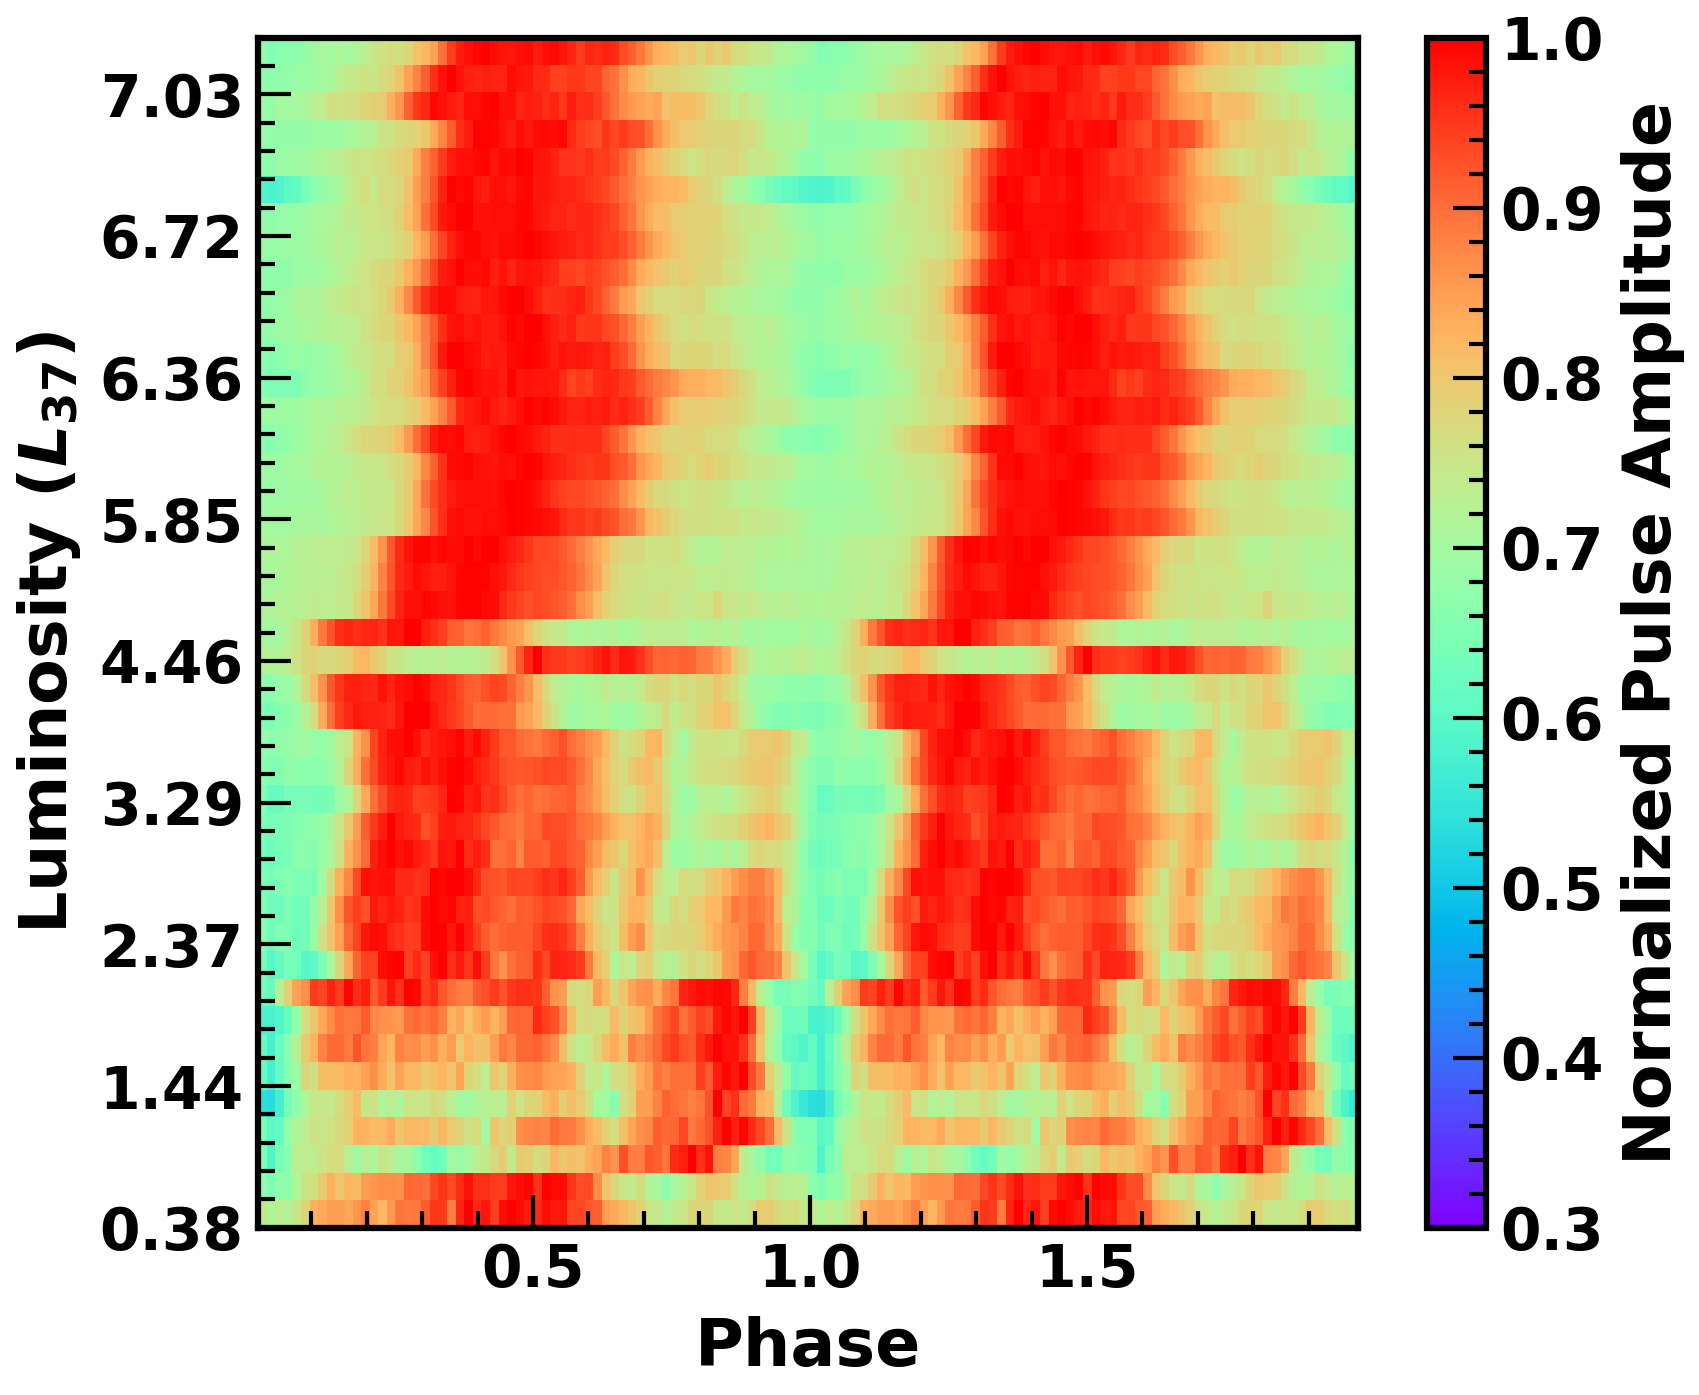

In [12]:
# Call the function for plotting
plot_pulse_profiles_by_luminosity(nicer_matched_files, nicer_matched_luminosities,"/home/supremekai/thesis/J0243_6p6124/pulVluminNICER_aligned.png")

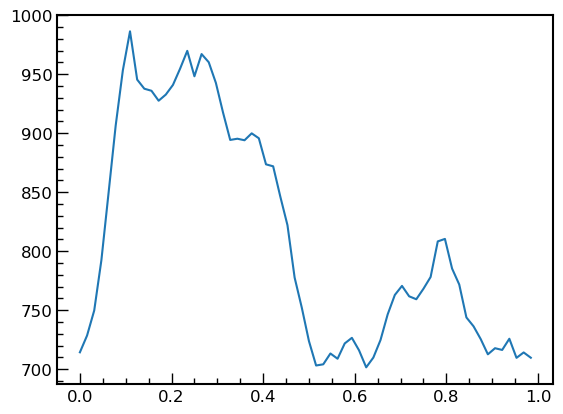

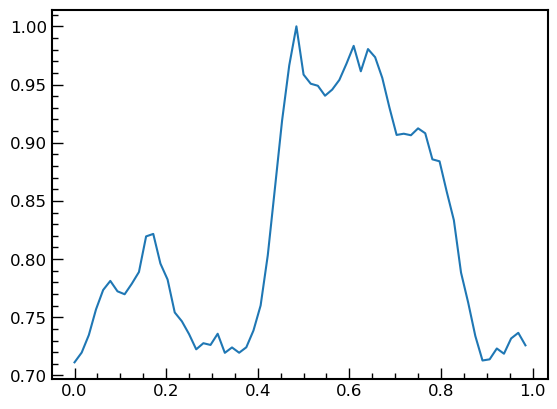

In [ ]:
from locale import normalize
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('astro')
data=fits.open('/home/supremekai/thesis/J0243_6p6124/NICER_second_run/folded_curves/6050390229/6050390229_pulse_profile_lc_files_efold_output_same_epoch.fits')[1].data
phase=data['PHASE']
normalized_flux=data['RATE1']/np.max(data['RATE1'])

aligned_phase, aligned_flux = align_pulse_to_minimum(phase, normalized_flux)
plt.plot(data['PHASE'],data['RATE1'])
plt.show()
plt.plot(aligned_phase,aligned_flux)
plt.show()